In [1]:
# 3L_SDVRP


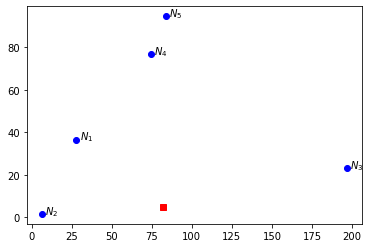

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multinomial
from scipy.stats import dirichlet
from py3dbp import Packer, Bin, Item
import math
import random
%matplotlib inline
import pylab as pl
from IPython import display

# "rnd" is an object that generate random numbers
rnd = np.random
#"seed(0)" is a method that reset (every time), the same random set of numbers
rnd.seed(0)
# Number of collection points
n_customer = 5
# The set of nodes without the depot.
N = [i for i in range(1,n_customer+1)]
# The set of nodes + the depot.
V = [0]+ N
# The Number of cargoes
Cat = 9
# Generating items for each collection point
IT = []
for i in N:
    cargo_set_=[]
    for j in range (1,Cat + 1):
        cargo_set_.append({(i,j):[rnd.randint(1, kk) for kk in [10,10,10,100]]})
    IT.append(cargo_set_)
IT_num = [(i,j) for i in N for j in range(1, Cat + 1)]
# Number of Vehicles
nv = 3
# Max volume and Max weight that each vehicle can carry
Container_vehicle = [('vehicle_%d'%kk, rnd.randint(30, 50), rnd.randint(30, 50), rnd.randint(30, 50), rnd.randint(100, 500)) for kk in range(0,nv) ]
# Generating random numbers between (0 and 15) * 200.
xc = rnd.rand(n_customer+1)*200
# Generating random numbers between (0 and 15) * 100.
yc = rnd.rand(n_customer+1)*100
# The number of Routing plans
RP = 10
#Plotting the n nodes without the node 0 (depot) and chose the color blue for each node.
plt.scatter(xc[1:],yc[1:],c='b')
# Associating and plotting each demand in the right of each blue node (customer).
for i in N:
    plt.annotate('$N_%d$'%(i),(xc[i]+2,yc[i]))
# Ploting the node 0, chosing the red like its color and the square form like a marker.
plt.plot(xc[0],yc[0],c='r' ,marker='s')
# Showing the Initial plot.
plt.show()
# Intializing the set of arcs A.
A = [(i,j) for i in V for j in V if i!=j]
# Calculating the distance between each node as non-negative cost of each arc
dist= {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in A}
# Generating historical data wich show how many times each route has been chosen
historical_routes = [rnd.randint(1, 100)/100 for i in range(0, len(A))]

In [2]:
import dirichlet
help(dirichlet)
dirichlet.meanprecision(np.array(historical_routes))
dirichlet.mle(np.array(10,5), tol=1e-07, method='meanprecision', maxiter=None)

In [55]:
# Vehicle Route Planning Module

# alpha = np.array(historical_routes) # alpha is an array of our historical data for each edge

def findRoutPlans(alpha):

    drichlet_mean = dirichlet.mean(alpha)
    multinomial_ed = multinomial.rvs(300, drichlet_mean, size=RP*2)

    # Finding Edges
    semi_final_path = []
    for routplansiterator in range(0, len(multinomial_ed)):
        sorted_edges=[]
        for maxifinder in range(max(multinomial_ed[routplansiterator]), -1, -1):
            finded = np.where(multinomial_ed[routplansiterator] == maxifinder)
            sorted_edges.append(finded[0])

        first_path = []
        for hh in sorted_edges:
            for ff in hh:
                # Checking for duplicate collection points
                if len(first_path)>0:
                    first_elements = [i for i,j in first_path]
                    second_elements = [j for i,j in first_path]
                    if A[ff][0] not in first_elements and A[ff][1] not in second_elements:
                        first_path.append(A[ff])
                else:
                    first_path.append(A[ff])
                    
        semi_final_path.append(first_path[0:n_customer])
    
    # Removing invalids
    numfailed = []
    for rpiterator in range(0,len(semi_final_path)):
        starting_point=0
        for jkl in semi_final_path[rpiterator]:
            starting_point=starting_point+1
            for lkj in semi_final_path[rpiterator][starting_point:]:
                if (jkl[1] == lkj[0] and jkl[0] == lkj[1]):
                    numfailed.append(rpiterator)
                    
    final_path = [i for n, i in enumerate(semi_final_path) if n not in numfailed]
    
    return final_path


In [56]:
# Collection points that vehicle should pass

def collectionPointsFinder(final_path):

    allocatedCPs=[]
    CPs=[]

    for y in range(0,len(final_path)):
        for i, j in final_path[y]:
            CPs.append(i)
            CPs.append(j)
        allocatedCPs.append(set(myset))
        
    return allocatedCPs


In [142]:
# Splitting Module

# Sorting
def splitCargoes(alpha_s, nv):
    
    multinomial_ed_s=[]
    for alpha_s_inside in alpha_s:
        drichlet_mean_s = dirichlet.mean(alpha_s_inside)
        multinomial_ed_s.append(multinomial.rvs(300, drichlet_mean_s, size=1))

    # Choosing Cargoes
    final_set = []
    
    for cargoewclassiterator in range(0, len(multinomial_ed_s)):
        sorted_cargoes=[]
        for maxfinder in range(max(multinomial_ed_s[cargoewclassiterator][0]), -1, -1):
            if maxfinder>0:
                finded_cargoes = np.where(multinomial_ed_s[cargoewclassiterator][0] == maxfinder)
                sorted_cargoes.append(finded_cargoes[0])

        first_set = []
        for hh in sorted_cargoes:
            for ff in hh:
                first_set.append(IT[cargoewclassiterator][ff])

        final_set.append([first_set])

    # Cargoes for vehicles
    set_for_vehicles=[]
    
    for vehicle_num in range(0,nv):
        init_set=[]
        
        for custom_num in range(0,n_customer):
            init_set.append(final_set[custom_num][0][vehicle_num*round(Cat/nv):vehicle_num*round(Cat/nv)+round(Cat/nv)])
        set_for_vehicles.append(init_set)

    return set_for_vehicles, final_set

In [5]:
# Optimal 3D Loading Module

def loading(Container_vehicle, final_set):

    packer = Packer()
    # The maximum volum and weight that a container can carry (length, width, height, weight)
    # for vehicle_name, vehicle_width, vehicle_height, vehicle_depth, vehicle_weight in Container_vehicle:
        # Add bins Number of vehicles
        # packer.add_bin(Bin(vehicle_name, vehicle_width, vehicle_height, vehicle_depth, vehicle_weight)) 
    packer.add_bin(Bin(Container_vehicle[0],
                        Container_vehicle[1],
                        Container_vehicle[2],
                        Container_vehicle[3],
                        Container_vehicle[4]))

    # add corresponding items to containers
    for customeritems in final_set:
        for items in customeritems:
            # for boxes in items:
            packer.add_item(Item(list(items.keys())[0],
                                list(items.values())[0][0],
                                list(items.values())[0][1],
                                list(items.values())[0][2],
                                list(items.values())[0][3]))

    packer.pack(number_of_decimals=0)

    # for b in packer.bins:
    #     print(":::::::::::", b.string())

    #     print("FITTED ITEMS:")
    #     for item in b.items:
    #         print("====> ", item.string())

    #     print("UNFITTED ITEMS:")
    #     for item in b.unfitted_items:
    #         print("====> ", item.string())

    #     print("**************************")

    return packer

In [6]:
# Fitness Function 1
def fitnessFunction_1(pop):
# F1=[]
# for pop in init_pop_route:
    F1=[]
    for vehicles in range(0, len(pop)):
        route_cost = 0
        for i in pop[vehicles]:
            route_cost = route_cost + dist[i]
        F1.append(route_cost)
    return sum(F1)
    # F1.append(sum(F1_init))

In [341]:
# Fitness Function 2

def fitnessFunction_2(pc_items, pc_bins):

    # Calculate each container capacity
    containers_weight = [wgh[4] for wgh in Container_vehicle]
    containers_volume = [vol[1]*vol[2]*vol[3] for vol in Container_vehicle]

    # Calculate all items wgh and vol
    items_weight = []
    items_volume = []

    for boxes in pc_items:
        items_weight.append(sum([float(item.weight) for item in boxes]))
        items_volume.append(sum([float(item.get_volume()) for item in boxes]))

    # total_items_weight = np.array(items_weight)
    # total_items_volume = np.array(items_volume)

    # rvol_mean = np.sum(total_items_volume)/sum(containers_volume)
    # rwgh_mean = np.sum(total_items_weight)/sum(containers_weight)
    
    rvol_mean = sum(items_volume)/sum(containers_volume)
    rwgh_mean = sum(items_weight)/sum(containers_weight)

    # Calculate each vehicle bins items wgh and vol
    bins_fitteditems_weight = []
    bins_fitteditems_volume = []

    for contain in pc_bins:
        bins_fitteditems_weight.append(sum([float(item.weight) for item in contain[0].items]))
        bins_fitteditems_volume.append(sum([float(item.get_volume()) for item in contain[0].items]))
    # fitted_items_weight = np.array(bins_fitteditems_weight)
    # fitted_items_volume = np.array(bins_fitteditems_volume)

    # total_fitteditems_wgh = sum(np.sum(fitted_items_weight))
    # total_fitteditems_vol = sum(np.sum(fitted_items_volume))
    total_fitteditems_wgh = sum(bins_fitteditems_weight)
    total_fitteditems_vol = sum(bins_fitteditems_volume)

    F2 = 1/abs(abs(total_fitteditems_vol - total_fitteditems_wgh) - (total_fitteditems_vol + total_fitteditems_wgh))

    return F2

In [8]:
#Function to find index of list
def index_of(a,list):
    for i in range(0,len(list)):
        if list[i] == a:
            return i
    return -1

In [9]:
#Function to sort by values
def sort_by_values(list1, values):
    sorted_list = []
    while(len(sorted_list)!=len(list1)):
        if index_of(min(values),values) in list1:
            sorted_list.append(index_of(min(values),values))
        values[index_of(min(values),values)] = math.inf
    return sorted_list

In [10]:
#Function to calculate crowding distance
def crowding_distance(values1, values2, front):
    distance = [0 for i in range(0,len(front))]
    sorted1 = sort_by_values(front, values1[:])
    sorted2 = sort_by_values(front, values2[:])
    distance[0] = 999999999999999
    distance[len(front) - 1] = 999999999999999
    for k in range(1,len(front)-1):
        distance[k] = distance[k]+ (values1[sorted1[k+1]] - values2[sorted1[k-1]])/(max(values1)+1-min(values1))
    for k in range(1,len(front)-1):
        distance[k] = distance[k]+ (values1[sorted2[k+1]] - values2[sorted2[k-1]])/(max(values2)+1-min(values2))
    return distance

In [11]:
#Function to carry out NSGA-II's fast non dominated sort
def fast_non_dominated_sort(values1, values2):

    S=[[] for i in range(0,len(values1))]
    front = [[]]
    n=[0 for i in range(0,len(values1))]
    rank = [0 for i in range(0, len(values1))]

    for p in range(0,len(values1)):
        S[p]=[]
        n[p]=0
        for q in range(0, len(values1)):
            if (values1[p] < values1[q] and values2[p] < values2[q]) or (values1[p] <= values1[q] and values2[p] < values2[q]) or (values1[p] < values1[q] and values2[p] <= values2[q]):
                if q not in S[p]:
                    S[p].append(q)
            elif (values1[q] < values1[p] and values2[q] < values2[p]) or (values1[q] <= values1[p] and values2[q] < values2[p]) or (values1[q] < values1[p] and values2[q] <= values2[p]):
                n[p] = n[p] + 1
        if n[p]==0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)

    i = 0
    while(front[i] != []):
        Q=[]
        for p in front[i]:
            for q in S[p]:
                n[q] =n[q] - 1
                if( n[q]==0):
                    rank[q]=i+1
                    if q not in Q:
                        Q.append(q)
        i = i+1
        front.append(Q)
    del front[len(front)-1]
    return front

In [12]:
#Function to carry out the crossover
def crossover(pop1,pop2):

    mutation_prob = random.random()

    if mutation_prob > 0.5:
        pop1, pop2 = mutation(pop1, pop2)
    else:
        r1 = np.random.randint(1, len(pop1['route']))
        r2 = np.random.randint(1, len(pop1['route']))
        # if r>0.5:
        #     return mutation((a+b)/2)
        # else:
        #     return mutation((a-b)/2)
        route_1 = pop1['route'][r1]
        route_2 = pop2['route'][r2]
        pop1['route'][r1] = route_2
        pop2['route'][r2] = route_1

    return pop1, pop2


In [14]:
#Function to carry out the mutation operator
def mutation(pop1, pop2):
    r_ = random.random()
    r1 = np.random.randint(1, len(pop1['set']))
    r2 = np.random.randint(1, len(pop1['set']))
    if r_ > 0.5:
        set_1 = pop1['set'][r1]
        set_2 = pop1['set'][r2]
        pop1['set'][r1] = set_2
        pop1['set'][r2] = set_1
    else:
        set_1 = pop2['set'][r1]
        set_2 = pop2['set'][r2]
        pop2['set'][r1] = set_2
        pop2['set'][r2] = set_1

    return pop1, pop2

99

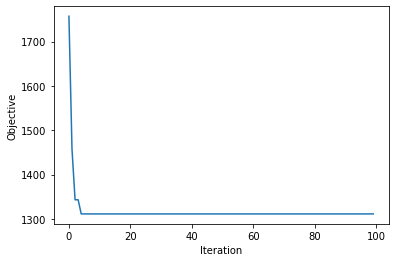

In [357]:
# Init Population

alpha = np.array(historical_routes)

split_prob=[]
for i in range (0, n_customer):
    split_prob.append([1 for i in range(0, len(IT[0]))])
alpha_s = np.array(split_prob)

pop_size = 100
pop = {}

max_gen = 100
gen_no = 0

minF1=[]
minF2=[]
maxF1=[]
maxF2=[]

while(gen_no<max_gen):
    for ind in range(0,pop_size):
        final_path = findRoutPlans(alpha)
        set_per_vehic, total_sets = splitCargoes(alpha_s, nv)
        
        pc_bins = []
        pc_items = []
        counter_sets = 0
        for vehicle_count in range(0,len(Container_vehicle)):
            pc = loading(Container_vehicle[vehicle_count], set_per_vehic[counter_sets])
            pc_bins.append(pc.bins)
            pc_items.append(pc.items)
            counter_sets = counter_sets + 1

        fitness_1 = fitnessFunction_1(final_path[0:len(Container_vehicle)])
        fitness_2 = fitnessFunction_2(pc_items, pc_bins)

        pop[ind] = {'route': final_path[0:len(Container_vehicle)],
                    'set': set_per_vehic,
                    'pack_bins': pc_bins,
                    'pack_items': pc_items,
                    'F1': fitness_1,
                    'F2': fitness_2
                    } 
    # Best Pareto Front
    objective1_values = [float(pop[i]['F1']) for i in range(0,len(pop))]
    objective2_values = [float(pop[i]['F2']) for i in range(0,len(pop))]
    non_dominated_sorted_solution = fast_non_dominated_sort(objective1_values[:],objective2_values[:])

    crowding_distance_values=[]
    for i in range(0,len(non_dominated_sorted_solution)):
            crowding_distance_values.append(crowding_distance(objective1_values[:],
                                            objective2_values[:],
                                            non_dominated_sorted_solution[i][:]))

    # Updating drichlet distributions

    for sol in non_dominated_sorted_solution[0]:
        # Updating routes distribution matrix
        for route in pop[sol]['route']:
            for edge in route:
                index = index_of(edge, A)
                alpha[index] = alpha[index] + 1
        # Updating Splitting distribution matrix
        for node in pop[sol]['set'][0]:
            for clus in node :
                alpha_s[list(clus.keys())[0][0]-1][list(clus.keys())[0][1]-1] = alpha_s[list(clus.keys())[0][0]-1][list(clus.keys())[0][1]-1] + 1
        for node in pop[sol]['set'][-1]:
            for clus in node :
                if alpha_s[list(clus.keys())[0][0]-1][list(clus.keys())[0][1]-1] > 1:
                    alpha_s[list(clus.keys())[0][0]-1][list(clus.keys())[0][1]-1] = alpha_s[list(clus.keys())[0][0]-1][list(clus.keys())[0][1]-1]-1
                else:
                    alpha_s[list(clus.keys())[0][0]-1][list(clus.keys())[0][1]-1] = 1
    function1 = [i * 1 for i in objective1_values]
    function2 = [j * 1 for j in objective2_values]

    minF1.append(min(function1))
    minF2.append(min(function2))
    maxF1.append(max(function1))
    maxF2.append(max(function2))
    display.clear_output(wait=True)
    display.display(gen_no)
    gen_no = gen_no + 1

# Plot Pareto front (for two scores only) 
#  
x = minF1
y = minF2
z = maxF1
k = maxF2
plt.xlabel('Iteration')
plt.ylabel('Objective')

plt.plot()
plt.show()

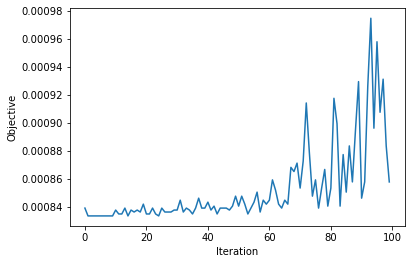

In [362]:
x = minF1
y = minF2
z = maxF1
k = maxF2
plt.xlabel('Iteration')
plt.ylabel('Objective')

plt.plot(y)
plt.show()

In [302]:
max_gen = 20
gen_no=0
minF1=[]
minF2=[]
maxF1=[]
maxF2=[]
while(gen_no<max_gen):
        objective1_values = [float(pop[i]['F1']) for i in range(0,len(pop))]
        objective2_values = [float(pop[i]['F2']) for i in range(0,len(pop))]
        non_dominated_sorted_solution = fast_non_dominated_sort(objective1_values[:],objective2_values[:])
        # print('Best Front for Generation:',1)
        # for values in non_dominated_sorted_solution[-1]:
        #     print(pop[values]['F1'],pop[values]['F2'] ,end=" ")
        # print("\n")
        crowding_distance_values=[]
        for i in range(0,len(non_dominated_sorted_solution)):
                crowding_distance_values.append(crowding_distance(objective1_values[:],
                                                objective2_values[:],
                                                non_dominated_sorted_solution[i][:]))
        non_dominated_sorted_solution
        pop2 = {}
        for i in range(0, len(pop)):
        pop2[i] = pop[i]
        ll=len(pop)
        while(len(pop2)!=2*pop_size):
        a1 = random.randint(0,pop_size-1)
        b1 = random.randint(0,pop_size-1)
        off_1, off_2 = crossover(pop[a1],pop[b1])
        pop2[ll] = off_1
        pop2[ll+1] = off_2

        pc1_bins = []
        pc1_items = []
        pc2_bins = []
        pc2_items = []

        counter_sets = 0

        for vehicle_count in range(0,len(Container_vehicle)):
                pc_1 = loading(Container_vehicle[vehicle_count], pop2[ll]['set'][counter_sets])
                pc_2 = loading(Container_vehicle[vehicle_count], pop2[ll+1]['set'][counter_sets])
                pc1_bins.append(pc_1.bins)
                pc1_items.append(pc_1.items)
                pc2_bins.append(pc_2.bins)
                pc2_items.append(pc_2.items)
                counter_sets = counter_sets + 1

        pop2[ll]['pack_bins'] = pc1_bins
        pop2[ll]['pack_items'] = pc1_items
        pop2[ll+1]['pack_bins'] = pc2_bins
        pop2[ll+1]['pack_items'] = pc2_items

        fitness_1_off_1 = fitnessFunction_1(pop2[ll]['route'])
        fitness_2_off_1 = fitnessFunction_2(pop2[ll]['pack_items'], pop2[ll]['pack_bins'])
        fitness_1_off_2 = fitnessFunction_1(pop2[ll+1]['route'])
        fitness_2_off_2 = fitnessFunction_2(pop2[ll+1]['pack_items'], pop2[ll+1]['pack_bins'])

        pop2[ll]['F1'] = fitness_1_off_1
        pop2[ll]['F2'] = fitness_2_off_1
        pop2[ll+1]['F1'] = fitness_1_off_2
        pop2[ll+1]['F2'] = fitness_2_off_2
        ll= ll + 2

        objective1_values2 = [float(pop2[i]['F1']) for i in range(0,len(pop2))]
        objective2_values2 = [float(pop2[i]['F2']) for i in range(0,len(pop2))]

        non_dominated_sorted_solution2 = fast_non_dominated_sort(objective1_values2[:],objective2_values2[:])
        # non_dominated_sorted_solution2.reverse()
        crowding_distance_values2=[]
        for i in range(0,len(non_dominated_sorted_solution2)):
        crowding_distance_values2.append(crowding_distance(objective1_values2[:],objective1_values2[:],non_dominated_sorted_solution2[i][:]))
        new_solution= []

        for i in range(0,len(non_dominated_sorted_solution2)):
        non_dominated_sorted_solution2_1 = [index_of(non_dominated_sorted_solution2[i][j],non_dominated_sorted_solution2[i] ) for j in range(0,len(non_dominated_sorted_solution2[i]))]
        front22 = sort_by_values(non_dominated_sorted_solution2_1[:], crowding_distance_values2[i][:])
        front = [non_dominated_sorted_solution2[i][front22[j]] for j in range(0,len(non_dominated_sorted_solution2[i]))]
        front.reverse()
        for value in front:
                new_solution.append(value)
                if(len(new_solution)==pop_size):
                break
        if (len(new_solution) == pop_size):
                break
        pop.clear()
        for sol in range(0, len(new_solution)):
        pop[sol] = pop2[new_solution[sol]]
        #Lets plot the final front now

        # function1 = [i * 1 for i in objective1_values[0:len(non_dominated_sorted_solution[0])]]
        # function2 = [j * 1 for j in objective2_values[0:len(non_dominated_sorted_solution[0])]]

        function1 = [i * 1 for i in objective1_values]
        function2 = [j * 1 for j in objective2_values]

        minF1.append(min(function1))
        minF2.append(min(function2))
        maxF1.append(max(function1))
        maxF2.append(max(function2))
        pl.clf()
        pl.scatter(function1,function2)

        display.clear_output(wait=True)
        display.display(pl.gcf())
        gen_no = gen_no + 1


[[10, 17],
 [8, 19, 34, 40, 42, 44],
 [2, 31, 7, 28, 36, 47],
 [14, 22, 49, 1, 6, 30, 37, 41],
 [35, 15, 32, 16, 25],
 [13, 23, 48, 3, 12, 21, 46],
 [27, 4, 29, 39],
 [5, 20, 9, 11, 26, 0],
 [33, 43, 18],
 [24],
 [45],
 [38]]

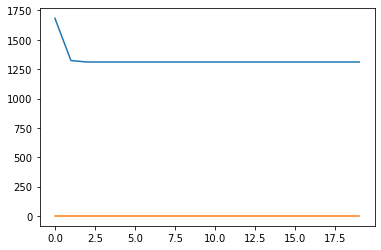

In [356]:
# Plot Pareto front (for two scores only) 
#  
x = minF1
y = minF2
z = maxF1
k = maxF2
# plt.xlabel('Objective A')
# plt.ylabel('Objective B')

plt.plot(z)
plt.plot(k)
# plt.savefig('pareto.png')
plt.show()

In [311]:
for i in pop[non_dominated_sorted_solution[0][0]]['route']:
    for j in i:
        print(historical_routes[j])


TypeError: list indices must be integers or slices, not tuple

In [169]:
# LP minimization module

from mip import CBC
from mip import Model, xsum, minimize, BINARY, maximize
Sload = 10
Qload = 10
s = [6, 2, 3, 4, 10, 4]
q = [10, 5, 6, 1, 8, 8]
A = len(q)
model = Model(sense = maximize, solver_name = CBC)
p = [model.add_var() for k in range(0, A)]
model.objective = maximize(xsum((s[k] + q[k]) * p[k] for k in range(0, A)))

model += xsum(s[k] * p[k] for k in range(0, A)) <=Sload
model += xsum(q[k] * p[k] for k in range(0, A)) <=Qload
for k in range(0, A):
    model += p[k] <=1
model.optimize(max_seconds = 300)
status = model.optimize()
print(status)
for k in range(0, A):
    print(p[k].x)
